In [190]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

from sklearn.metrics import mean_squared_error as mse

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [232]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

transformer_list = []
df_train
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


#### Обработка датасетов

Начнём с строковых признаков. Признаки HomePlanet и Destination имеют 3 значения, не включая NaN. Заменим NaN на наиболее частотное значение и закодируем оба признака числами от 0 до 2. При этом, признак HomePlanet будет кодироваться в порядке удаления небесного тела от солнца, как и Destination.

In [192]:
homeplanet_top = df_train['HomePlanet'].describe().top
destination_top  = df_train['Destination'].describe().top

def fillna_string(df: pd.DataFrame):
    df = df.copy()
    
    df['HomePlanet'] = (df['HomePlanet'].fillna(homeplanet_top))
    
    df['HomePlanet'] = df['HomePlanet'].replace('Earth', 0)
    df['HomePlanet'] = df['HomePlanet'].replace('Mars', 1)
    df['HomePlanet'] = df['HomePlanet'].replace('Europa', 2)
    
    df['Destination'] = (df['Destination'].fillna(destination_top))
    
    df['Destination'] = df['Destination'].replace('55 Cancri e', 0)
    df['Destination'] = df['Destination'].replace('PSO J318.5-22', 1)
    df['Destination'] = df['Destination'].replace('TRAPPIST-1e', 2)
    
    return df

if fillna_string not in transformer_list:
    transformer_list.append(fillna_string)

Рассмотрим булевые признаки. Признаки CryoSleep и VIP имеют 2 значения, не включая NaN. Заменим NaN на наиболее частотное значение.

In [193]:
cryosleep_top = df_train['CryoSleep'].describe().top
vip_top = df_train['VIP'].describe().top

def fillna_bool(df: pd.DataFrame):
    df = df.copy()
    
    df['CryoSleep'] = (df['CryoSleep'].fillna(cryosleep_top)).apply(lambda x: bool(x))
    df['VIP'] = (df['VIP'].fillna(vip_top)).apply(lambda x: bool(x))
    
    return df

if fillna_bool not in transformer_list:
    transformer_list.append(fillna_bool)

Рассмотрим признаки типа данных float. NaN значения признаков RoomService, FoodCourt, ShoppingMall, Spa и VRDeck заменим на наиболее частотное значение, а признак Age - на среднее значение.

In [194]:
age_mean = df_train['Age'].mean()

def fillna_float(df: pd.DataFrame):
    df = df.copy()
    
    df['Age'] = df['Age'].fillna(age_mean)
    
    df['RoomService'] = df['RoomService'].fillna(0)
    df['FoodCourt'] = df['FoodCourt'].fillna(0)
    df['ShoppingMall'] = df['ShoppingMall'].fillna(0)
    df['Spa'] = df['Spa'].fillna(0)
    df['VRDeck'] = df['VRDeck'].fillna(0)
            
    return df

if fillna_float not in transformer_list:
    transformer_list.append(fillna_float)

Теперь обработаем комплексные признаки. Разделим признак PassengerId на 2 новых признака Group_number и Group_index. В призаке PassengerId нет значений NaN, следовательно и в новых признаках их не будет

In [195]:
def split_passenger(df: pd.DataFrame):
    df = df.copy()
    
    df['Group_number'] = df['PassengerId'].agg(lambda x: str(x).split('_')[0] if pd.notna(x) else x)
    df['Group_index'] = df['PassengerId'].agg(lambda x: str(x).split('_')[1] if pd.notna(x) else x)
    
    df['Group_number'] = df['Group_number'].apply(lambda x: float(x))
    df['Group_index'] = df['Group_index'].apply(lambda x: float(x))
    
    return df

if split_passenger not in transformer_list:
    transformer_list.append(split_passenger)

Разделим признак Cabin на 3 новых признака Cabin_deckб Cabin_num и Cabin_side. В призаке PassengerId нет значений NaN, следовательно и в новых признаках их не будет

In [196]:
def split_cabins(df: pd.DataFrame):
    df = df.copy()
    
    df['Cabin_deck'] = df['Cabin'].agg(lambda x: str(x).split('/')[0] if pd.notna(x) else x)
    df['Cabin_num'] = df['Cabin'].agg(lambda x: str(x).split('/')[1] if pd.notna(x) else x)
    df['Cabin_side'] = df['Cabin'].agg(lambda x: str(x).split('/')[2] if pd.notna(x) else x)
    
    df['Cabin_num'] = df['Cabin_num'].apply(lambda x: float(x))
    
    del df['Cabin']
    
    return df

if split_cabins not in transformer_list:
    transformer_list.append(split_cabins)

Дополнительно сгенерируем новый признак AmenitiesSum, как сумма признаков RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, которые хранят в себе число денег, потраченых на различные услуги.

In [197]:
def amenities_sum(df: pd.DataFrame):
    df = df.copy()
    
    df['AmenitiesSum'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    
    return df

if amenities_sum not in transformer_list:
    transformer_list.append(amenities_sum)

Для дальнейшего удобства работы с датасетом, примем как новый индекс PassengerId, а признак Name вовсе удалим.

In [198]:
def prepare_features(df: pd.DataFrame):
    df = df.copy()
    
    del df['Name']
    df = df.set_index('PassengerId')
    
    return df

if prepare_features not in transformer_list:
    transformer_list.append(prepare_features)

Обработаем новые признаки. Заменим значения NaN в признаке Cabin_deck и Cabin_side на наиболее частотные значения, а признак Cabin_num на среднее значение.

In [199]:
def fillna_cabin(df: pd.DataFrame, cabin_deck_top = 'N', cabin_num_mean = -1, cabin_side_top = 'N'):
    df = df.copy()
    
    if cabin_deck_top == 'N':
        cabin_deck_top = df['Cabin_deck'].describe().top
    else:
        cabin_deck_top = cabin_deck_top
        
    if cabin_num_mean == -1:
        cabin_num_mean = df['Cabin_num'].mean()
    else:
        cabin_num_mean = cabin_num_mean
        
    if cabin_side_top == 'N':
        cabin_side_top = df['Cabin_side'].describe().top
    else:
        cabin_side_top = cabin_side_top
    
    df['Cabin_deck'] = df['Cabin_deck'].fillna(cabin_deck_top)
    df['Cabin_num'] = df['Cabin_num'].fillna(cabin_num_mean)
    df['Cabin_side'] = df['Cabin_side'].fillna(cabin_side_top)
    
    return df

Теперь воспользуемся всеми функциями как на тренеровочной так и на тестовой выборке. А также закодируем признаки Cabin_deck и Cabin_side с помощью LabelEncoder

In [200]:
df_train_transformed = df_train.copy()

for f in transformer_list:
    df_train_transformed = f(df_train_transformed)

df_train_transformed = fillna_cabin(df_train_transformed)
    
cabin_deck_top = df_train_transformed['Cabin_deck'].describe().top
cabin_num_mean = df_train_transformed['Cabin_num'].mean()
cabin_side_top = df_train_transformed['Cabin_side'].describe().top

encoder = LabelEncoder()

df_train_transformed['Cabin_deck'] = encoder.fit_transform(df_train_transformed['Cabin_deck'])
df_train_transformed['Cabin_side'] = encoder.fit_transform(df_train_transformed['Cabin_side'])
df_train_transformed

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_number,Group_index,Cabin_deck,Cabin_num,Cabin_side,AmenitiesSum
PassengerId,,,,,,,,,,,,,,,,,
0001_01,2,False,2,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,1.0,1,0.0,0,0.0
0002_01,0,False,2,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,1.0,5,0.0,1,736.0
0003_01,2,False,2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,1.0,0,0.0,1,10383.0
0003_02,2,False,2,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3.0,2.0,0,0.0,1,5176.0
0004_01,0,False,2,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4.0,1.0,5,1.0,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,2,False,0,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,9276.0,1.0,0,98.0,0,8536.0
9278_01,0,True,1,18.0,False,0.0,0.0,0.0,0.0,0.0,False,9278.0,1.0,6,1499.0,1,0.0
9279_01,0,False,2,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,9279.0,1.0,6,1500.0,1,1873.0


In [201]:
df_test_transformed = df_test.copy()

for f in transformer_list:
    df_test_transformed = f(df_test_transformed)

df_test_transformed = fillna_cabin(df_test_transformed, cabin_deck_top, cabin_num_mean, cabin_side_top)

encoder = LabelEncoder()

df_test_transformed['Cabin_deck'] = encoder.fit_transform(df_test_transformed['Cabin_deck'])
df_test_transformed['Cabin_side'] = encoder.fit_transform(df_test_transformed['Cabin_side'])
df_test_transformed

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_number,Group_index,Cabin_deck,Cabin_num,Cabin_side,AmenitiesSum
PassengerId,,,,,,,,,,,,,,,,
0013_01,0,True,2,27.00000,False,0.0,0.0,0.0,0.0,0.0,13.0,1.0,6,3.000000,1,0.0
0018_01,0,False,2,19.00000,False,0.0,9.0,0.0,2823.0,0.0,18.0,1.0,5,4.000000,1,2832.0
0019_01,2,True,0,31.00000,False,0.0,0.0,0.0,0.0,0.0,19.0,1.0,2,0.000000,1,0.0
0021_01,2,False,2,38.00000,False,0.0,6652.0,0.0,181.0,585.0,21.0,1.0,2,1.000000,1,7418.0
0023_01,0,False,2,20.00000,False,10.0,0.0,635.0,0.0,0.0,23.0,1.0,5,5.000000,1,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,0,True,2,34.00000,False,0.0,0.0,0.0,0.0,0.0,9266.0,2.0,6,1496.000000,1,0.0
9269_01,0,False,2,42.00000,False,0.0,847.0,17.0,10.0,144.0,9269.0,1.0,5,600.367671,1,1018.0
9271_01,1,True,0,28.82793,False,0.0,0.0,0.0,0.0,0.0,9271.0,1.0,3,296.000000,0,0.0


#### Анализ фичей

Проанализируем числовые значения на предмет нормальности распределения, чтобы убедится в корректности заполнения NaN значений.

In [202]:
def draw_densety(ser_new: pd.Series):
    fig, ax = plt.subplots()
    fig.figure.set_figwidth(16)
    fig.figure.set_figheight(9)
    plt.xlabel('Значение')
    plt.ylabel('Вероятность, доли')
    plt.title(ser_new.name)

    mean = ser_new.mean()
    median = ser_new.median()
    min_ = ser_new.min()
    max_ = ser_new.max()
    std = ser_new.std()

    sns.histplot(ser_new,
                 bins=15,
                 kde=True,
                 color = 'red',
                 stat="density",
                 kde_kws=dict(cut=5))

    normal_plot = scipy.stats.norm(mean, std)
    to_plot = np.linspace(ser_new.min(), ser_new.max(), 100)
    plt.plot(to_plot,
             normal_plot.pdf(to_plot),
             color = 'black',
             ls = '--')

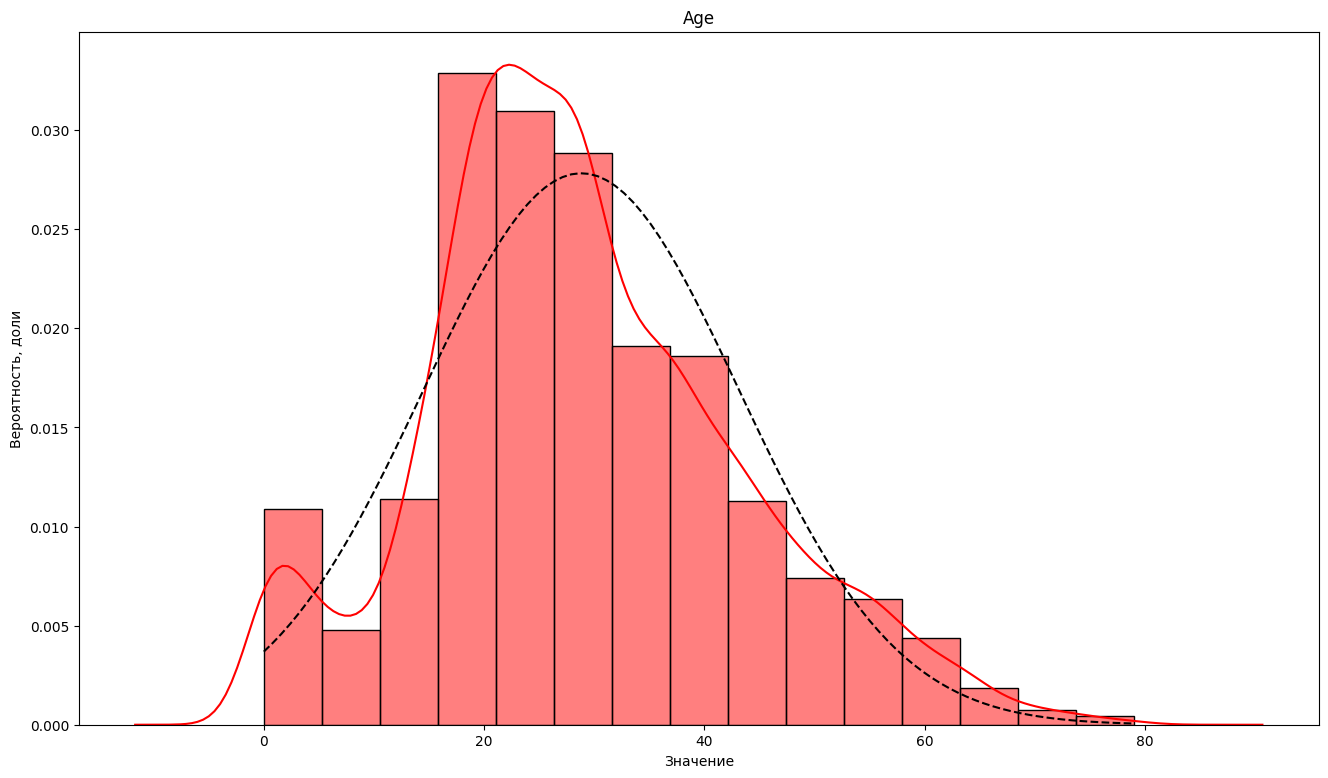

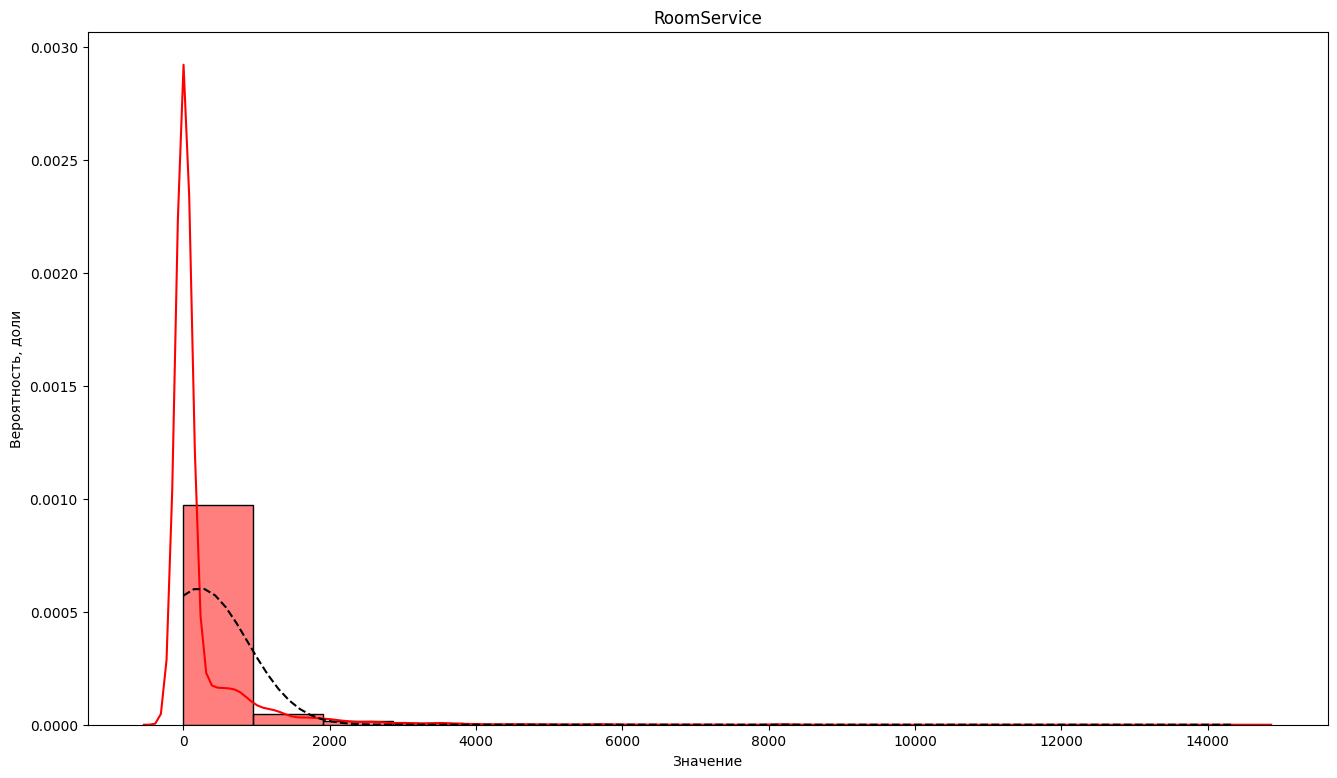

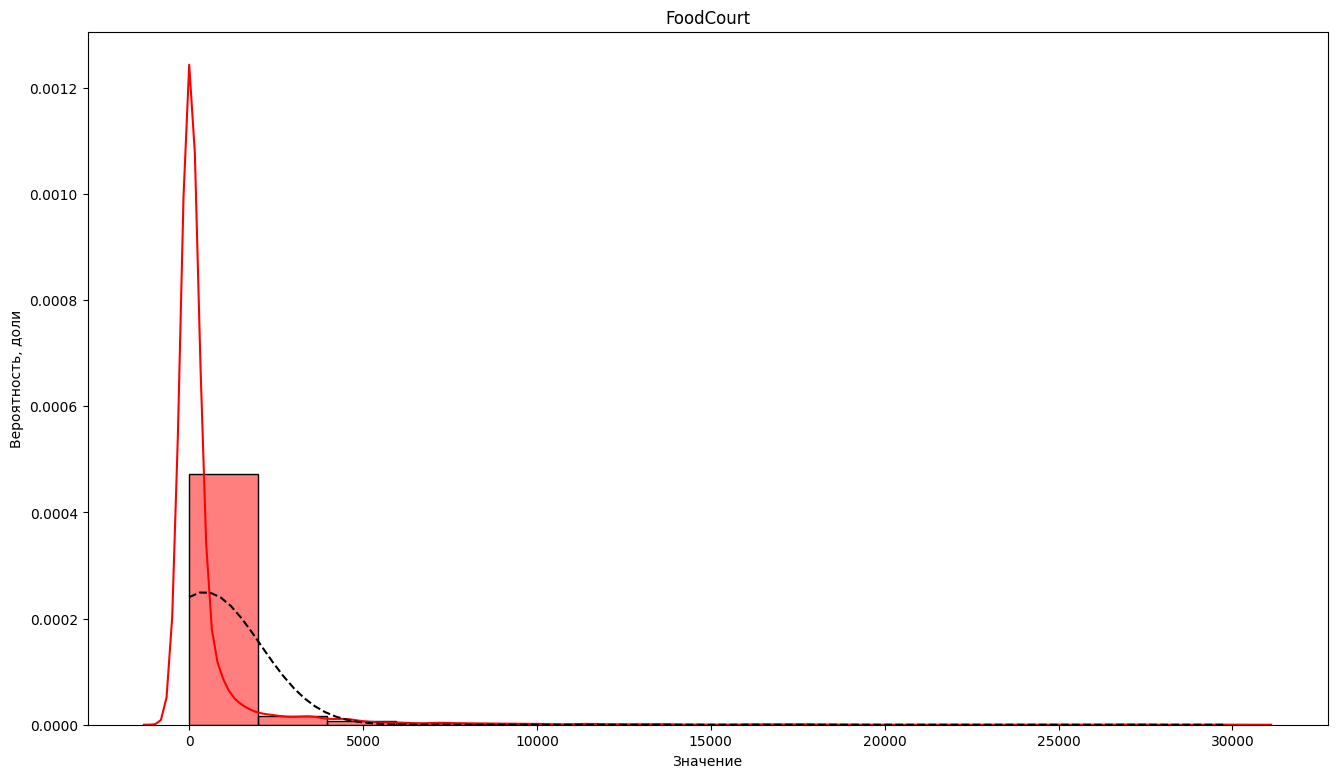

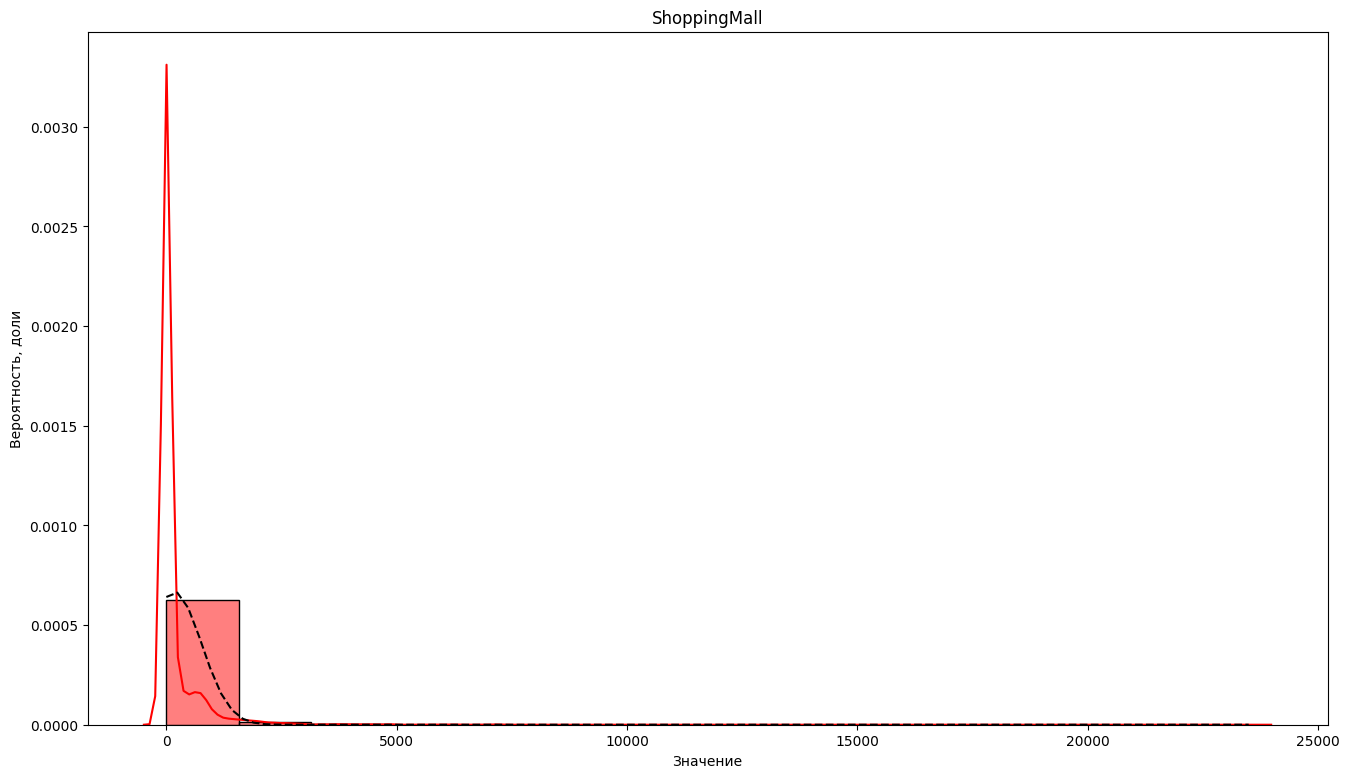

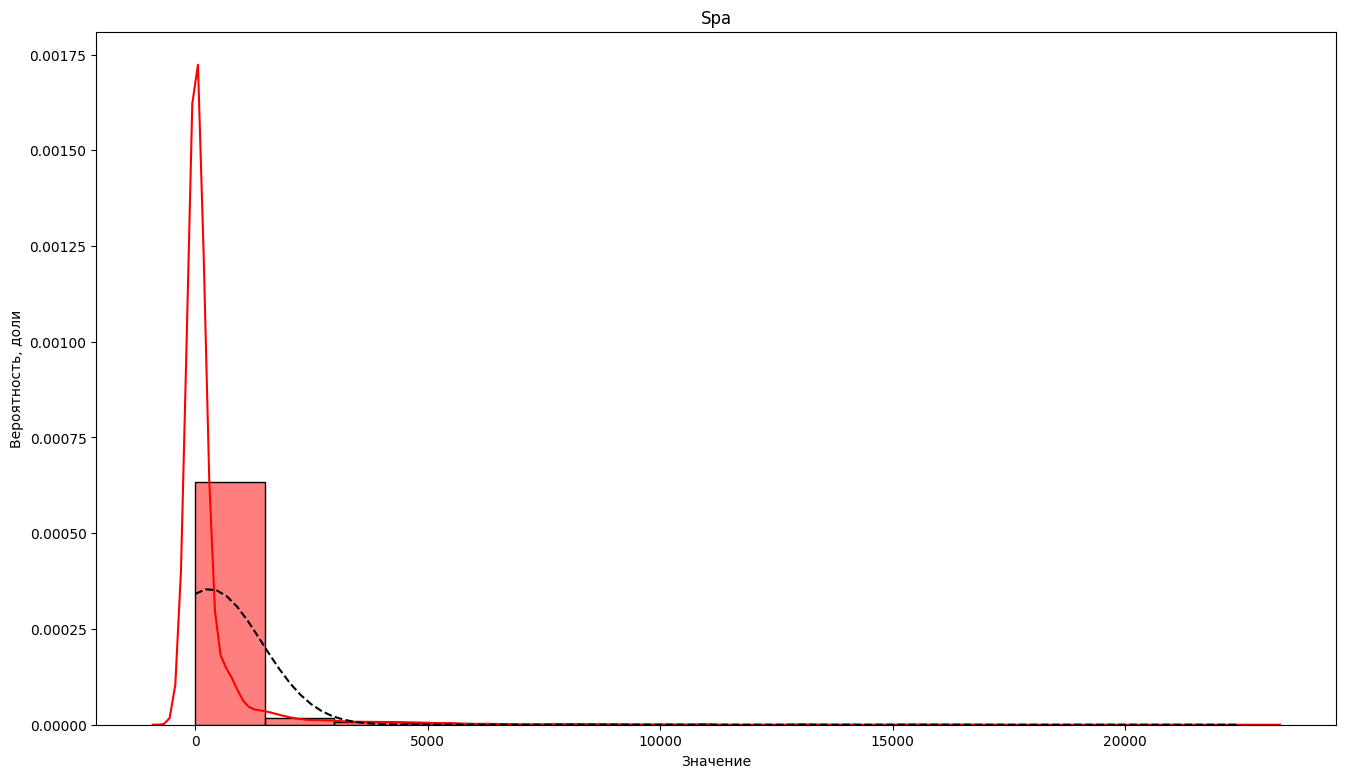

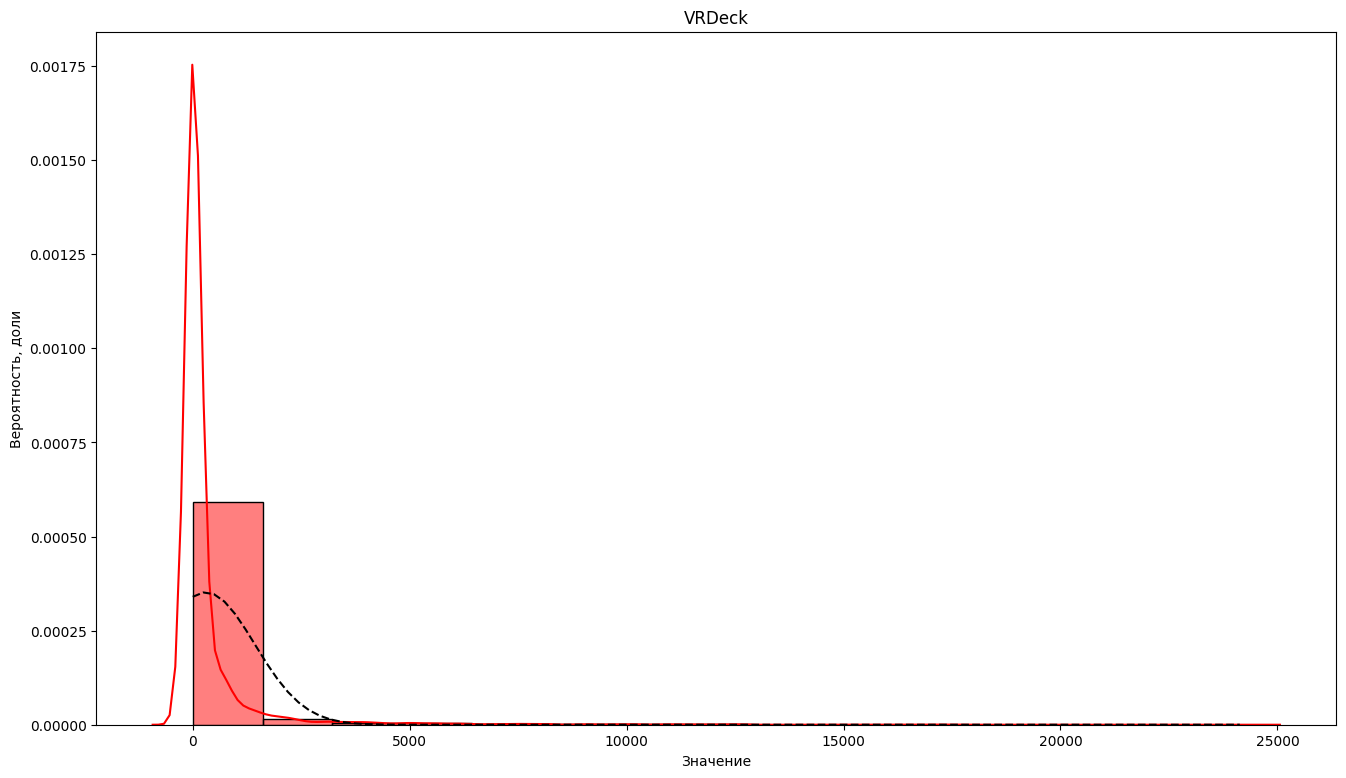

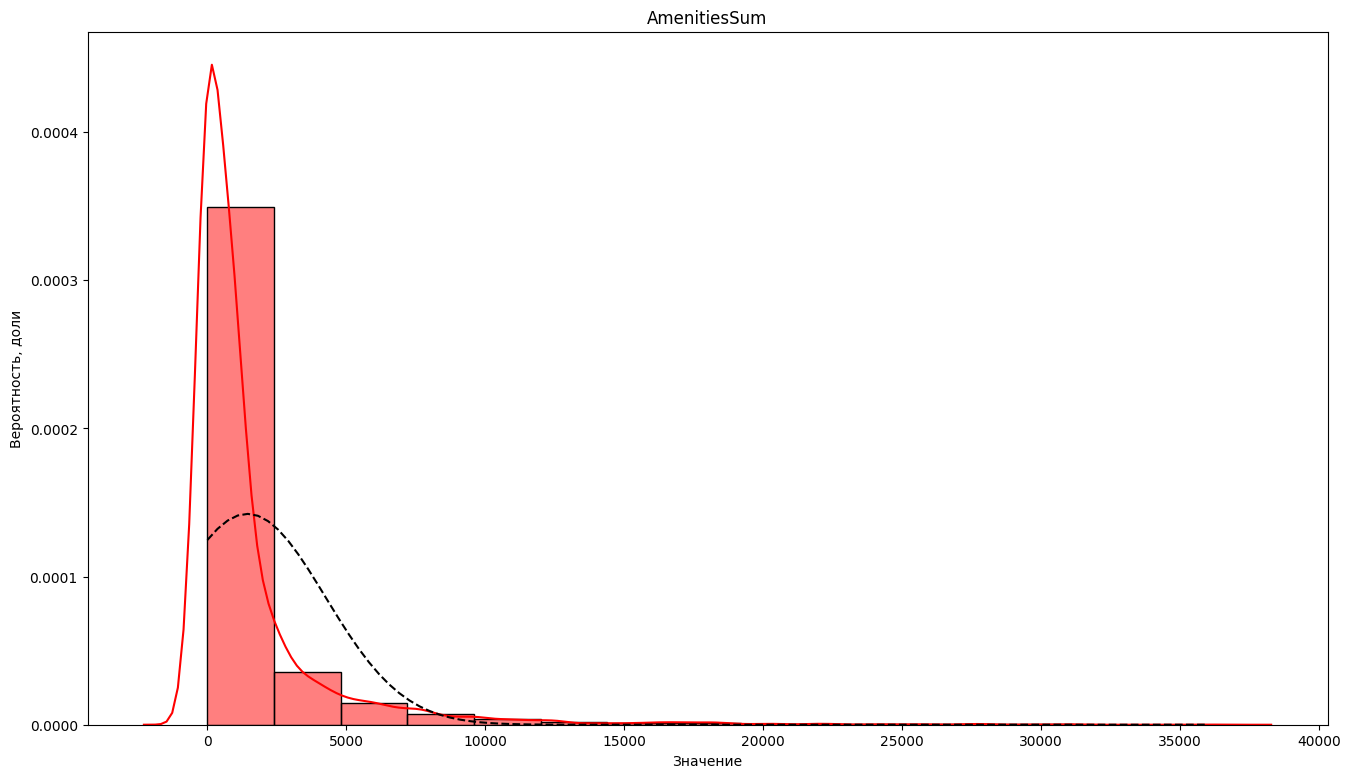

In [203]:
for c in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'AmenitiesSum']:
    ser = df_train_transformed[c]
    draw_densety(ser)

Как можно заметить по графикам данные признаки распределены не нормально. Однако все признаки кроме Age, похожи на log-нормальное распределение. Проверим это, взяв натуральный логорифм от каждого из значений признаков, исключая значения 0.

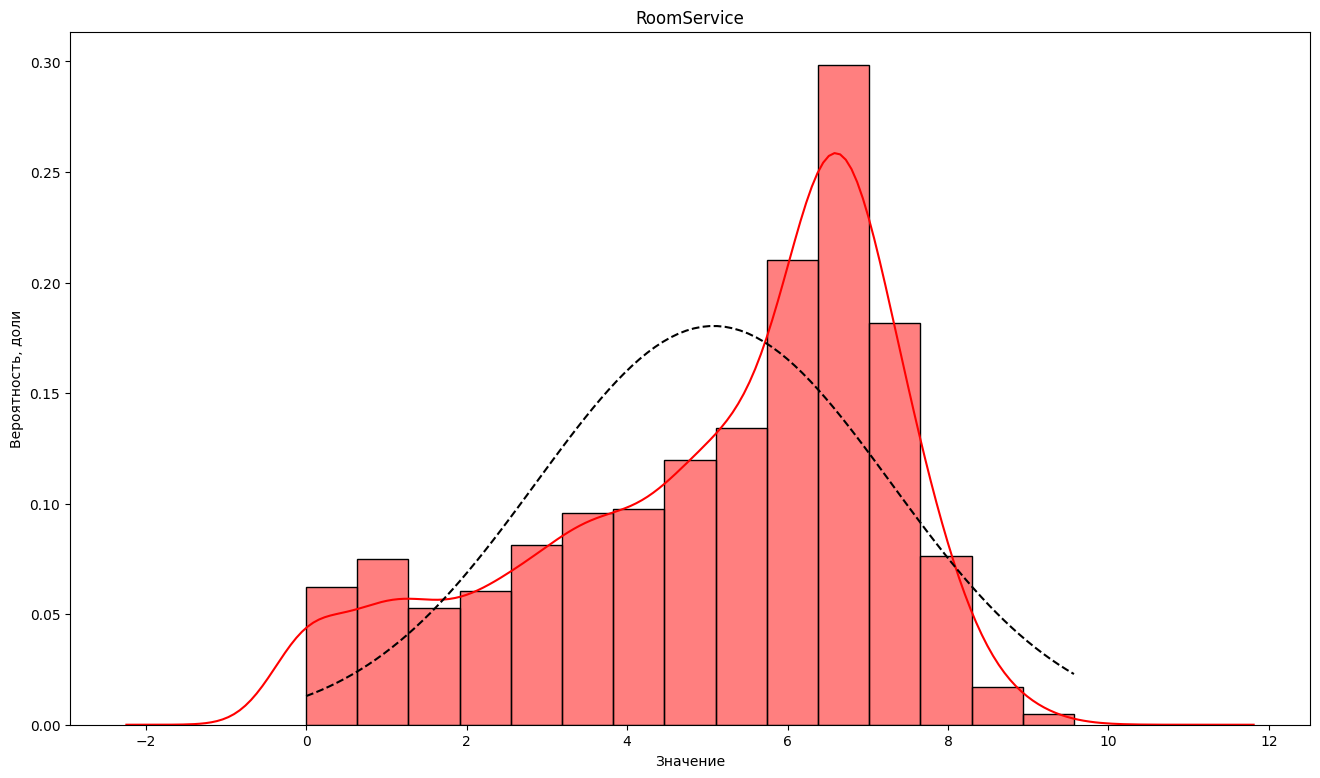

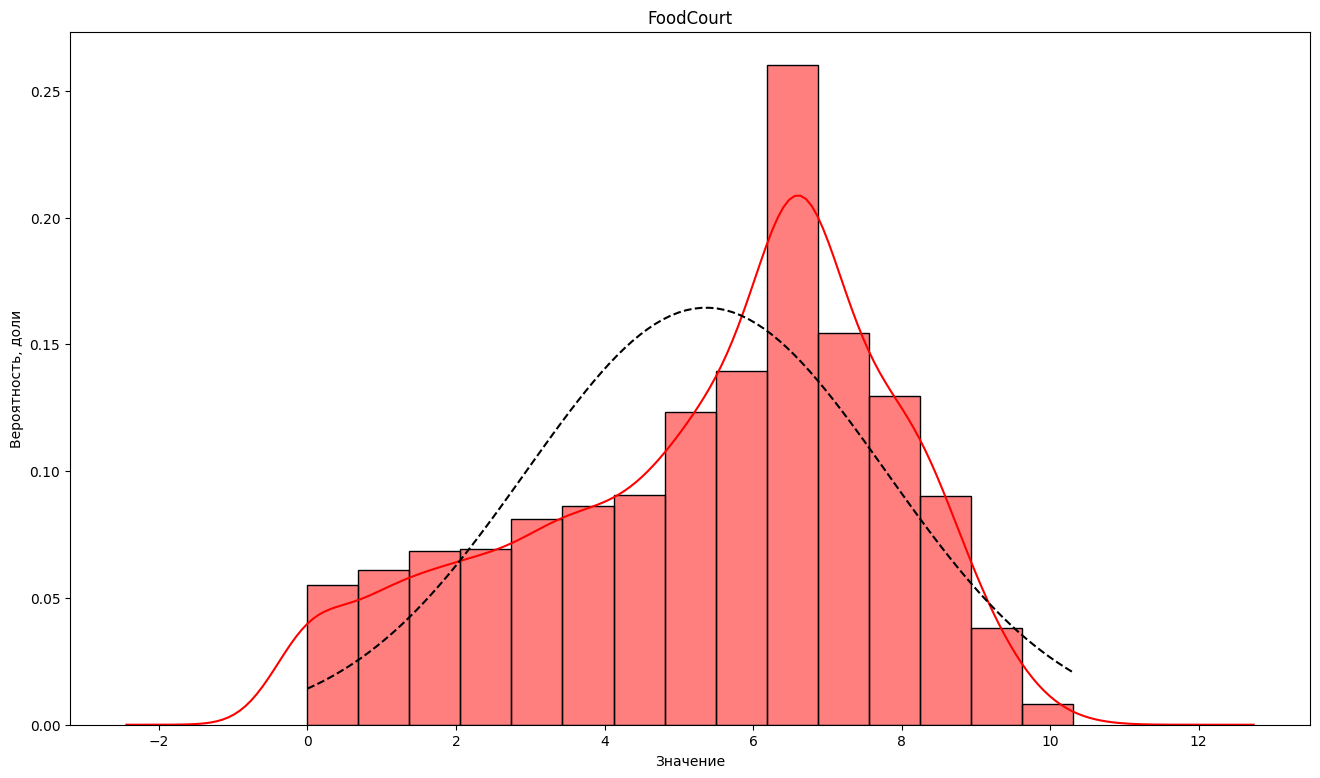

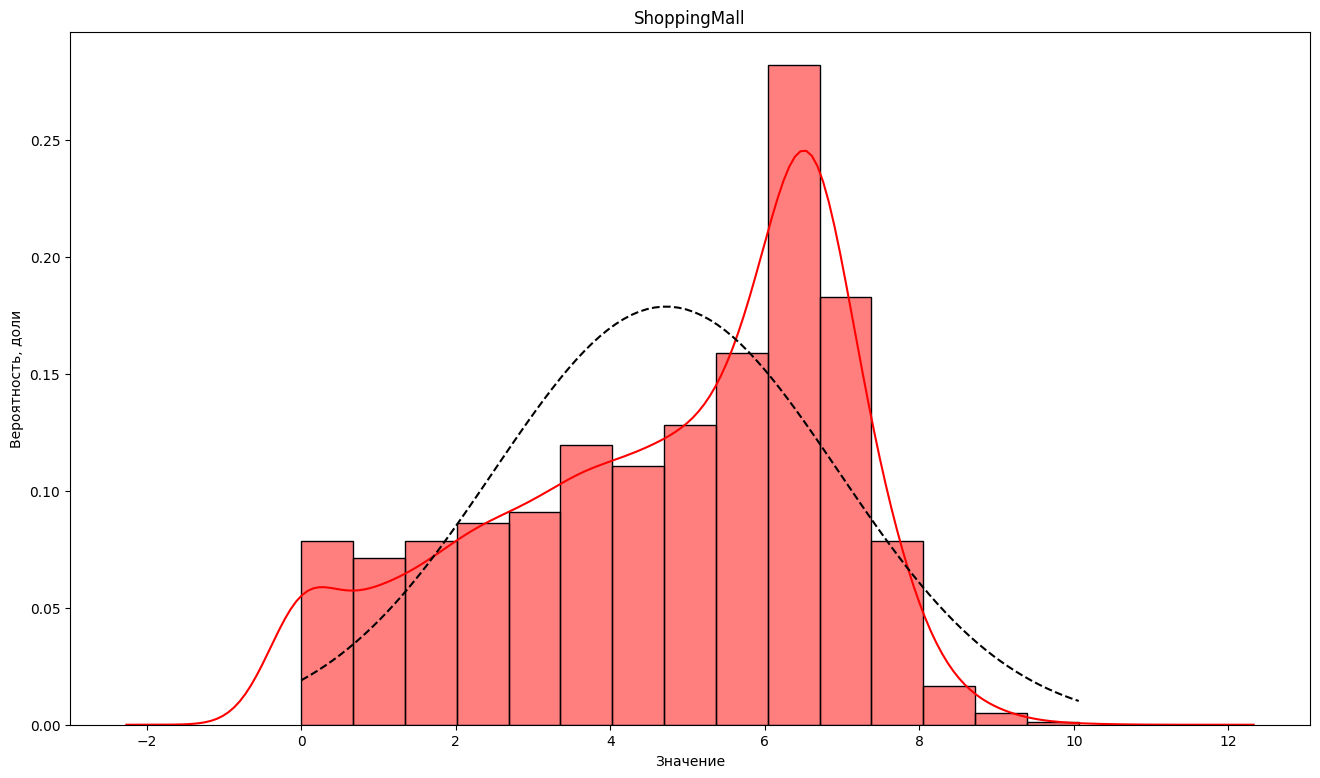

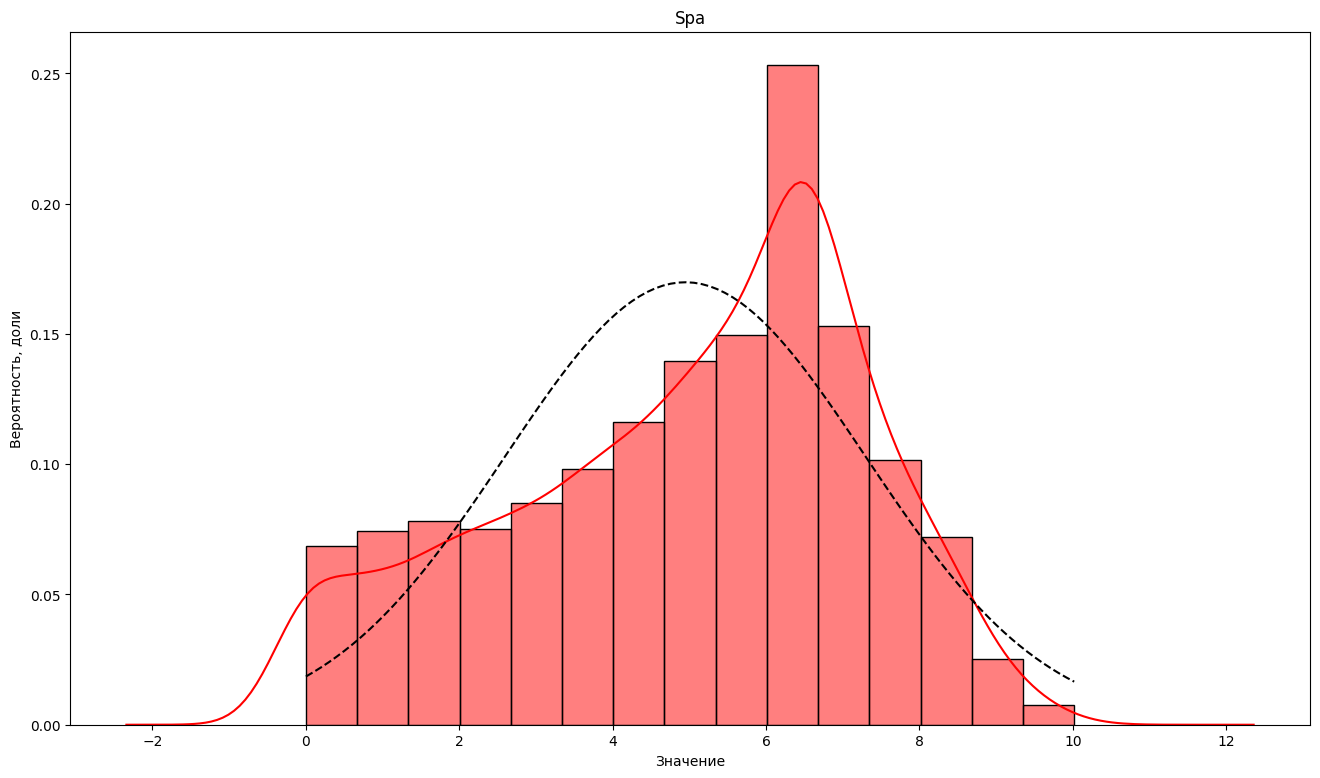

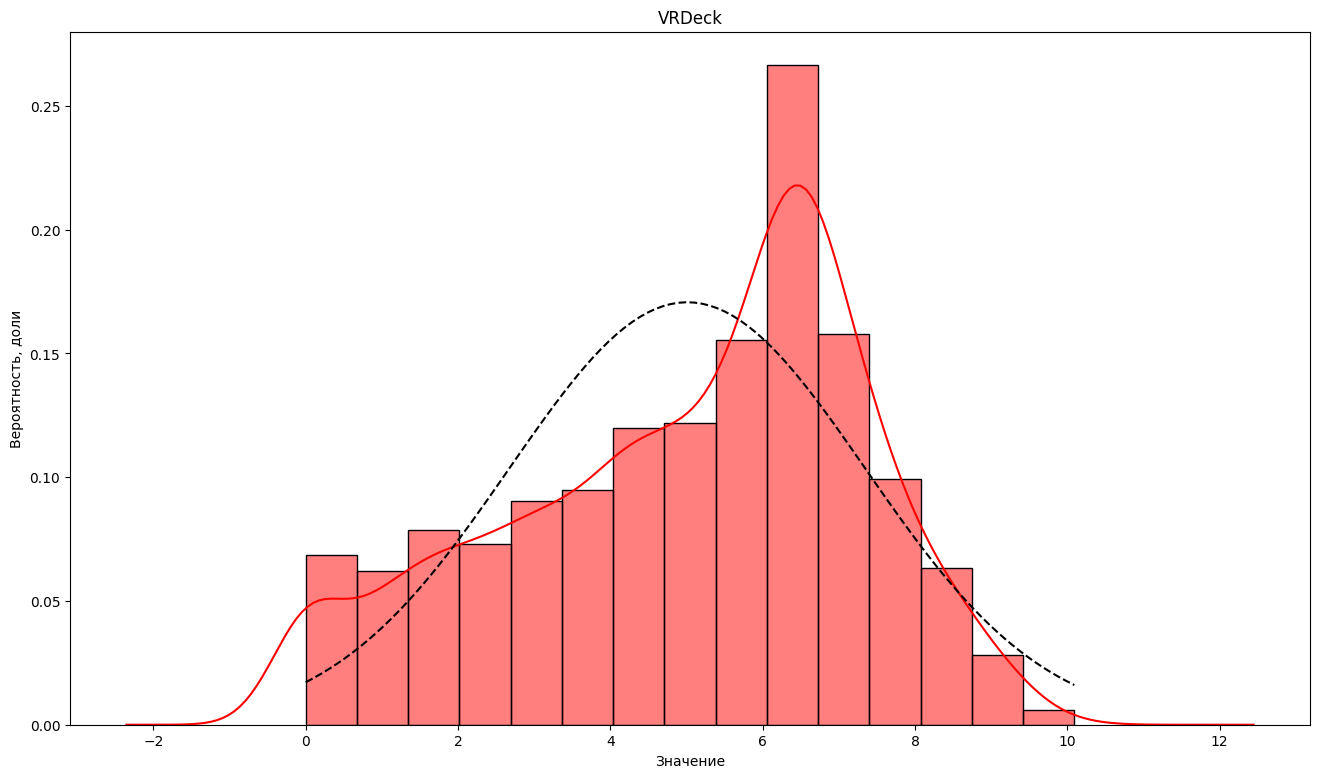

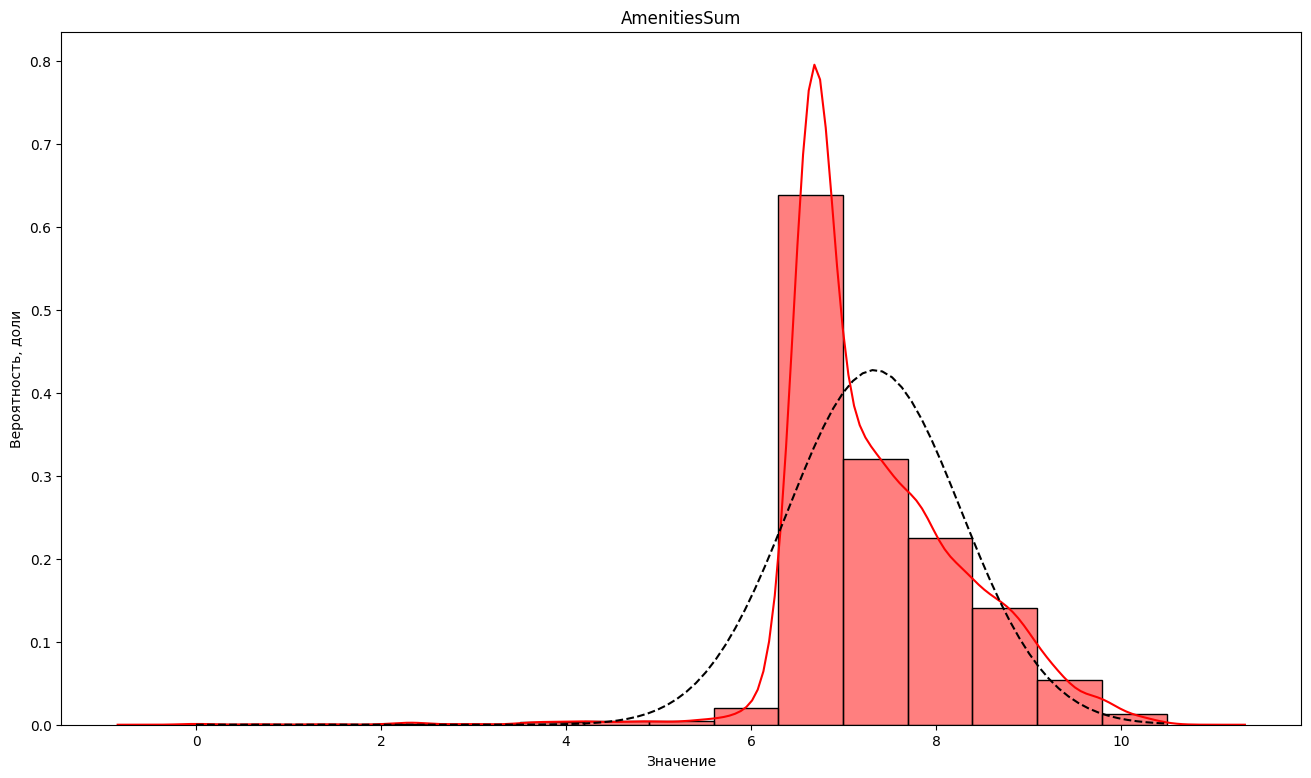

In [204]:
for c in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'AmenitiesSum']:
    ser = df_train_transformed[c].copy()
    # ser += 1
    ser = ser[ser > 0]
    ser = np.log(ser)
    # ser = ser ** 0.5
    draw_densety(ser)

Как можно видеть признаки распределены не нормально.

#### Создание модели

Поставим задачу о создании Blending модели. В качестве базовых моделей используем следующие модели:
* LogisticRegression
* KNeighbors
* DecisionTree
* RandomForest
* CatBoost
* LGBM

In [205]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Разделим тренировочну выборку на тренировочную и валидационную

In [206]:
X_main = df_train_transformed.drop(columns=["Transported"])
y_main = df_train_transformed["Transported"]

X_train, X_valid, y_train, y_valid = train_test_split(X_main, y_main, test_size=0.25, random_state=13, shuffle=False)
X_test = df_test_transformed

scaler = StandardScaler()
scaler.fit(X_train, y_train)

X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), index = X_valid.index, columns = X_valid.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

Создадим функцию для отображения качества модели на каждой итерации

In [207]:
def get_predict(model, X_train, X_valid, X_test, y_train, y_valid, index = '', catboost = False):
    model = model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    if catboost:
        for i in range(len(train_pred)):
            if train_pred[i] == 'True':
                train_pred[i] = True
            else:
                train_pred[i] = False

        for i in range(len(valid_pred)):
            if valid_pred[i] == 'True':
                valid_pred[i] = True
            else:
                valid_pred[i] = False

    train_pred = train_pred.astype(bool)
    valid_pred = valid_pred.astype(bool)
    
    train_error_pred = f1_score(y_train, train_pred)
    valid_error_pred = f1_score(y_valid, valid_pred)
    mean_error_pred = (train_error_pred * len(X_train) + valid_error_pred * len(X_valid)) / (len(X_train) + len(X_valid))
    
    print(f"{index} {str(type(model)).split('.')[-1][:-2]}\tF1 train: {train_error_pred:.3f} valid: {valid_error_pred:.3f} mean: {mean_error_pred:.3f}")

    valid_pred = model.predict_proba(X_valid)
    test_pred  = model.predict_proba(X_test)
    
    valid_pred = pd.DataFrame(valid_pred)[1]
    test_pred = pd.DataFrame(test_pred)[1]
    
    return valid_pred, test_pred, valid_error_pred

Для будущего анализа и создания мета-модели, будем записывать результаты обучения и самим модели в отдельные списки.

In [208]:
valid_list = []
test_list = []
model_list = []

Обучим линейную регрессию

In [209]:
model = LogisticRegression()
valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid)

valid_list.append(valid_pred)
test_list.append(test_pred)
model_list.append(model)

 LogisticRegression	F1 train: 0.800 valid: 0.786 mean: 0.796


Методом перебора по сетке, найдём наилучшую модель KNN по значению на валидационной выборке.

In [210]:
best_model = {0 : 0}

for n in range(2, 20):
    model = KNeighborsClassifier(n)
    valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid, index = f'[n = {n}]')

    if (max(best_model.keys())) < score:
        best_model[score] = n
        
best_neighbors = best_model[max(best_model.keys())]
        
print(f'Лучшая итерация c кол-вом соседей равным {best_neighbors} с скором {max(best_model.keys()):.3f}')

[n = 2] KNeighborsClassifier	F1 train: 0.866 valid: 0.731 mean: 0.832
[n = 3] KNeighborsClassifier	F1 train: 0.879 valid: 0.762 mean: 0.850
[n = 4] KNeighborsClassifier	F1 train: 0.841 valid: 0.753 mean: 0.819
[n = 5] KNeighborsClassifier	F1 train: 0.853 valid: 0.765 mean: 0.831
[n = 6] KNeighborsClassifier	F1 train: 0.826 valid: 0.755 mean: 0.808
[n = 7] KNeighborsClassifier	F1 train: 0.832 valid: 0.761 mean: 0.814
[n = 8] KNeighborsClassifier	F1 train: 0.815 valid: 0.750 mean: 0.798
[n = 9] KNeighborsClassifier	F1 train: 0.821 valid: 0.762 mean: 0.806
[n = 10] KNeighborsClassifier	F1 train: 0.808 valid: 0.754 mean: 0.794
[n = 11] KNeighborsClassifier	F1 train: 0.815 valid: 0.766 mean: 0.803
[n = 12] KNeighborsClassifier	F1 train: 0.803 valid: 0.765 mean: 0.793
[n = 13] KNeighborsClassifier	F1 train: 0.810 valid: 0.767 mean: 0.799
[n = 14] KNeighborsClassifier	F1 train: 0.804 valid: 0.764 mean: 0.794
[n = 15] KNeighborsClassifier	F1 train: 0.811 valid: 0.764 mean: 0.800
[n = 16] KNeig

In [211]:
model = KNeighborsClassifier(best_neighbors)
valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid)

valid_list.append(valid_pred)
test_list.append(test_pred)
model_list.append(model)

 KNeighborsClassifier	F1 train: 0.810 valid: 0.767 mean: 0.799


Методом перебора по сетке, найдём наилучшую модель DT по значению на валидационной выборке.

In [212]:
best_model = {0 : 0}

for d in range(3, 9):
    for l in range(20, 30):
        model = DecisionTreeClassifier(max_depth = d, min_samples_leaf = l)
        valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid, f'[d = {d} | l = {l}]')

        if (max(best_model.keys())) < score:
            best_model[score] = (d, l)

best_depth = best_model[max(best_model.keys())][0]
best_min_samples_leaf = best_model[max(best_model.keys())][1]
RandomForestClassifier()
print(f'Лучшая итерация depth = {best_depth}, min_samples_leaf = {best_min_samples_leaf} с скором {max(best_model.keys()):.3f}')

[d = 3 | l = 20] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 21] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 22] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 23] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 24] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 25] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 26] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 27] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 28] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 3 | l = 29] DecisionTreeClassifier	F1 train: 0.784 valid: 0.780 mean: 0.783
[d = 4 | l = 20] DecisionTreeClassifier	F1 train: 0.797 valid: 0.794 mean: 0.797
[d = 4 | l = 21] DecisionTreeClassifier	F1 train: 0.797 valid: 0.794 mean: 0.797
[d = 4 | l = 22] DecisionTre

In [213]:
model = DecisionTreeClassifier(max_depth = best_depth, min_samples_leaf = best_min_samples_leaf)
valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid)

valid_list.append(valid_pred)
test_list.append(test_pred)
model_list.append(model)

 DecisionTreeClassifier	F1 train: 0.797 valid: 0.794 mean: 0.797


Методом перебора по сетке, найдём наилучшую модель RF по значению на валидационной выборке.

In [214]:
best_model = {0 : 0}

for e in [50, 100, 200, 300, 500]:
    for d in range(6, 11, 1):
        for f in range(6, 11, 1):
            model = RandomForestClassifier(n_jobs = -1, n_estimators = e, max_depth = d, max_features = f, random_state = 13)
            valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid, f'[e = {e} d = {d} f = {f}]')

            if (max(best_model.keys())) < score:
                best_model[score] = (e, d, f)

best_estimators = best_model[max(best_model.keys())][0]
best_depth = best_model[max(best_model.keys())][1]
best_max_features = best_model[max(best_model.keys())][2]

print(f'Лучшая итерация estimators = {best_estimators} depth = {best_depth}, best_max_features = {best_max_features} с скором {max(best_model.keys()):.3f}')

[e = 50 d = 6 f = 6] RandomForestClassifier	F1 train: 0.823 valid: 0.810 mean: 0.820
[e = 50 d = 6 f = 7] RandomForestClassifier	F1 train: 0.828 valid: 0.810 mean: 0.823
[e = 50 d = 6 f = 8] RandomForestClassifier	F1 train: 0.828 valid: 0.807 mean: 0.822
[e = 50 d = 6 f = 9] RandomForestClassifier	F1 train: 0.827 valid: 0.811 mean: 0.823
[e = 50 d = 6 f = 10] RandomForestClassifier	F1 train: 0.825 valid: 0.811 mean: 0.821
[e = 50 d = 7 f = 6] RandomForestClassifier	F1 train: 0.837 valid: 0.812 mean: 0.831
[e = 50 d = 7 f = 7] RandomForestClassifier	F1 train: 0.840 valid: 0.814 mean: 0.834
[e = 50 d = 7 f = 8] RandomForestClassifier	F1 train: 0.841 valid: 0.810 mean: 0.833
[e = 50 d = 7 f = 9] RandomForestClassifier	F1 train: 0.842 valid: 0.810 mean: 0.834
[e = 50 d = 7 f = 10] RandomForestClassifier	F1 train: 0.844 valid: 0.803 mean: 0.834
[e = 50 d = 8 f = 6] RandomForestClassifier	F1 train: 0.858 valid: 0.815 mean: 0.847
[e = 50 d = 8 f = 7] RandomForestClassifier	F1 train: 0.862 val

In [215]:
model = RandomForestClassifier(n_jobs = -1, n_estimators = best_estimators, max_depth = best_depth, max_features = best_max_features, random_state = 13)
valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid)

valid_list.append(valid_pred)
test_list.append(test_pred)
model_list.append(model)

 RandomForestClassifier	F1 train: 0.842 valid: 0.817 mean: 0.836


In [219]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Методом перебора по сетке, найдём наилучшую модель CatBoost по значению на валидационной выборке.

In [220]:
best_model = {0 : 0}

for i in range(50, 80, 10):
    for lr in np.linspace(0.001, 0.3, 10):
        for d in range(2, 7):
            model = CatBoostClassifier(iterations = i, learning_rate = lr, max_depth = d, random_state = 13, verbose = 0)
            valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid, f'[i = {i} lr = {lr:.3f} d = {d}]', catboost = True)

            if (max(best_model.keys())) < score:
                best_model[score] = (i, lr, d)

best_iterations = best_model[max(best_model.keys())][0]
best_learning_rate = best_model[max(best_model.keys())][1]
best_depth = best_model[max(best_model.keys())][2]

print(f'Лучшая итерация iterations = {best_iterations} learning_rate = {best_learning_rate}, depth = {best_depth} с скором {max(best_model.keys()):.3f}')

[i = 50 lr = 0.001 d = 2] CatBoostClassifier	F1 train: 0.710 valid: 0.731 mean: 0.715
[i = 50 lr = 0.001 d = 3] CatBoostClassifier	F1 train: 0.711 valid: 0.731 mean: 0.716
[i = 50 lr = 0.001 d = 4] CatBoostClassifier	F1 train: 0.724 valid: 0.746 mean: 0.730
[i = 50 lr = 0.001 d = 5] CatBoostClassifier	F1 train: 0.758 valid: 0.772 mean: 0.762
[i = 50 lr = 0.001 d = 6] CatBoostClassifier	F1 train: 0.773 valid: 0.779 mean: 0.774
[i = 50 lr = 0.034 d = 2] CatBoostClassifier	F1 train: 0.729 valid: 0.750 mean: 0.734
[i = 50 lr = 0.034 d = 3] CatBoostClassifier	F1 train: 0.746 valid: 0.766 mean: 0.751
[i = 50 lr = 0.034 d = 4] CatBoostClassifier	F1 train: 0.774 valid: 0.788 mean: 0.778
[i = 50 lr = 0.034 d = 5] CatBoostClassifier	F1 train: 0.794 valid: 0.803 mean: 0.796
[i = 50 lr = 0.034 d = 6] CatBoostClassifier	F1 train: 0.802 valid: 0.798 mean: 0.801
[i = 50 lr = 0.067 d = 2] CatBoostClassifier	F1 train: 0.770 valid: 0.791 mean: 0.775
[i = 50 lr = 0.067 d = 3] CatBoostClassifier	F1 train:

In [221]:
model = CatBoostClassifier(verbose = 0, iterations = best_iterations, learning_rate = best_learning_rate, max_depth = best_depth, random_seed = 13)
valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid, catboost = True)

valid_list.append(valid_pred)
test_list.append(test_pred)
model_list.append(model)

 CatBoostClassifier	F1 train: 0.843 valid: 0.816 mean: 0.836


Методом перебора по сетке, найдём наилучшую модель LGBM по значению на валидационной выборке.

In [222]:
best_model = {0 : 0}

for l in range(10, 21, 1):
    for lr in np.linspace(0.001, 0.3, 20):
        for d in range(2, 7):
            model = LGBMClassifier(num_leaves = l, max_depth = d, learning_rate = lr, random_state = 13)
            valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid, f'[l = {l} lr = {lr:.3f} d = {d}]')

            if (max(best_model.keys())) < score:
                best_model[score] = (l, lr, d)

best_num_leaves = best_model[max(best_model.keys())][0]
best_learning_rate = best_model[max(best_model.keys())][1]
best_depth = best_model[max(best_model.keys())][2]

print(f'Лучшая итерация num_leaves = {best_num_leaves} learning_rate = {best_learning_rate}, depth = {best_depth} с скором {max(best_model.keys()):.3f}')

[l = 10 lr = 0.001 d = 2] LGBMClassifier	F1 train: 0.753 valid: 0.759 mean: 0.754
[l = 10 lr = 0.001 d = 3] LGBMClassifier	F1 train: 0.786 valid: 0.782 mean: 0.785
[l = 10 lr = 0.001 d = 4] LGBMClassifier	F1 train: 0.798 valid: 0.795 mean: 0.797
[l = 10 lr = 0.001 d = 5] LGBMClassifier	F1 train: 0.798 valid: 0.797 mean: 0.798
[l = 10 lr = 0.001 d = 6] LGBMClassifier	F1 train: 0.798 valid: 0.797 mean: 0.798
[l = 10 lr = 0.017 d = 2] LGBMClassifier	F1 train: 0.742 valid: 0.765 mean: 0.748
[l = 10 lr = 0.017 d = 3] LGBMClassifier	F1 train: 0.803 valid: 0.802 mean: 0.803
[l = 10 lr = 0.017 d = 4] LGBMClassifier	F1 train: 0.811 valid: 0.808 mean: 0.810
[l = 10 lr = 0.017 d = 5] LGBMClassifier	F1 train: 0.814 valid: 0.808 mean: 0.812
[l = 10 lr = 0.017 d = 6] LGBMClassifier	F1 train: 0.813 valid: 0.805 mean: 0.811
[l = 10 lr = 0.032 d = 2] LGBMClassifier	F1 train: 0.779 valid: 0.790 mean: 0.782
[l = 10 lr = 0.032 d = 3] LGBMClassifier	F1 train: 0.815 valid: 0.804 mean: 0.812
[l = 10 lr = 0.0

In [223]:
model = LGBMClassifier(num_leaves = best_num_leaves, max_depth = best_depth, learning_rate = best_learning_rate, random_state = 13)
valid_pred, test_pred, score = get_predict(model, X_train, X_valid, X_test, y_train, y_valid)

valid_list.append(valid_pred)
test_list.append(test_pred)
model_list.append(model)

 LGBMClassifier	F1 train: 0.849 valid: 0.817 mean: 0.841


#### Создание мета-модели

Для удобства, создадим 2 датафрейма из ранее записаных результатов по валидационной и по тестовой выборки

In [224]:
df_new_valid = pd.DataFrame(valid_list[0].rename(0))
df_new_test = pd.DataFrame(test_list[0].rename(0))

for i in range(1, len(valid_list)):
    df_new_valid = pd.merge(df_new_valid, valid_list[i].rename(i), left_index=True, right_index=True)
    df_new_test = pd.merge(df_new_test, test_list[i].rename(i), left_index=True, right_index=True)

In [225]:
df_new_valid.to_csv('df_new_valid.csv')
df_new_test.to_csv('df_new_test.csv')

Обучим мета-модель с помолью линейной регрессии и установим разделение между True и False на зачении 0.5. Так же рассмотрим коэффициенты модели

In [226]:
model = LinearRegression()
model = model.fit(df_new_valid, y_valid)

pred = model.predict(df_new_test)

p = []
for i in range(len(pred)):
    if pred[i] >= 0.50:
        p.append(True)
    else:
        p.append(False)

# print(sum(p))
print(model.coef_)
print(sum(model.coef_))

[ 0.01895646 -0.06922515 -0.01653825 -0.02249575  0.5767848   0.52612489]
1.013607000302493


In [227]:
result = pd.Series(p, df_test['PassengerId'], name = 'Transported')
result.to_csv('sample_submission.csv')

На kagle данная модель получила скор равный 0.81248, что является 130 местом.

Попробуем улучшить качество предсказания за счёт коррекции постобработки предсказания. Для этого будем сдвигать границу между True и False и проверять качество модели как на общей тренировочной (тренировочная + валидационная) и тестовой выборки. Если на обоих выборках скор будет расти - значит мы сможем оставить новую границу.

In [228]:
main_list = []

for m in model_list:
    m.fit(X_main, y_main)
    main_pred = m.predict_proba(X_main)
    main_list.append(pd.DataFrame(main_pred)[1])


df_new_main = pd.DataFrame(main_list[0].rename(0))
for i in range(1, len(valid_list)):
    df_new_main = pd.merge(df_new_main, main_list[i].rename(i), left_index=True, right_index=True)
    
pred = model.predict(df_new_main)

p = []
for i in range(len(pred)):
    if pred[i] >= 0.50:
        p.append(True)
    else:
        p.append(False)

print(f1_score(y_main, p))

0.8266542404473439


Выбирем новую границу равной 0.49

In [229]:
model = LinearRegression()
model = model.fit(df_new_valid, y_valid)

pred = model.predict(df_new_test)

p = []
for i in range(len(pred)):
    if pred[i] >= 0.49:
        p.append(True)
    else:
        p.append(False)

# print(sum(p))
print(model.coef_)
print(sum(model.coef_))

[ 0.01895646 -0.06922515 -0.01653825 -0.02249575  0.5767848   0.52612489]
1.013607000302493


In [230]:
result = pd.Series(p, df_test['PassengerId'], name = 'Transported')
result.to_csv('sample_submission.csv')

На kagle данная модель получила скор равный 0.81342, что является 79 местом.

In [231]:
main_list = []

for m in model_list:
    m.fit(X_main, y_main)
    main_pred = m.predict_proba(X_main)
    main_list.append(pd.DataFrame(main_pred)[1])


df_new_main = pd.DataFrame(main_list[0].rename(0))
for i in range(1, len(valid_list)):
    df_new_main = pd.merge(df_new_main, main_list[i].rename(i), left_index=True, right_index=True)
    
pred = model.predict(df_new_main)

p = []
for i in range(len(pred)):
    if pred[i] >= 0.49:
        p.append(True)
    else:
        p.append(False)

print(f1_score(y_main, p))

0.8304053278217937


Так как скор вырос на обоих выборках, можно сказать, что коррекция границы разделения True и False является успешной